# Inspecting encoded spike train
### as grayscale image

## 1. Training the STAL Encoder

With no Z1 Z2 in the loss func

torch.Size([784]) tensor(5)
Total Learnable Parameters (LAST): 3713024


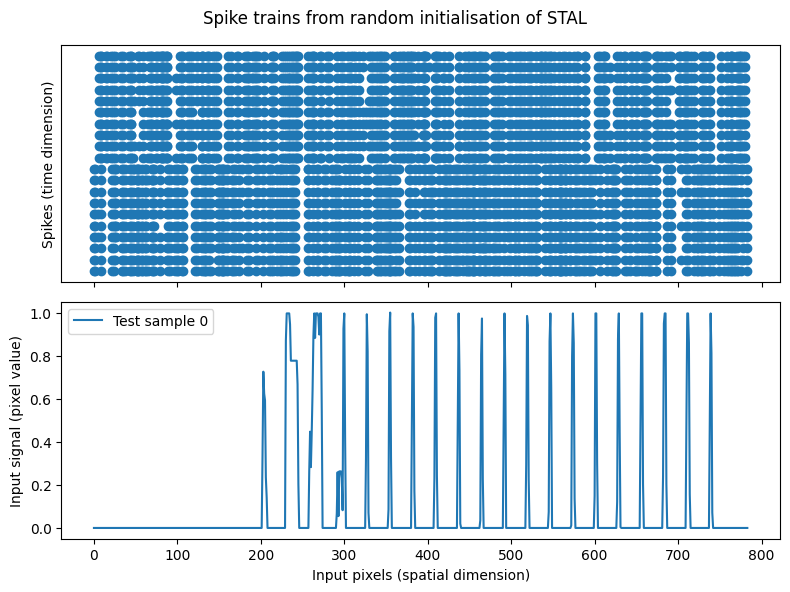

Default Loss initialized.
Epoch 1 - Train Loss: -2793.314
	- Validation Loss: -3165.037
Epoch 2 - Train Loss: -3256.759
	- Validation Loss: -3299.707
Epoch 3 - Train Loss: -3334.542
	- Validation Loss: -3340.072
Epoch 4 - Train Loss: -3374.093
	- Validation Loss: -3398.113
Epoch 5 - Train Loss: -3471.489
	- Validation Loss: -3493.147
Epoch 6 - Train Loss: -3525.618
	- Validation Loss: -3526.140
Epoch 7 - Train Loss: -3551.970
	- Validation Loss: -3544.620
Epoch 8 - Train Loss: -3571.613
	- Validation Loss: -3564.712
Epoch 9 - Train Loss: -3585.530
	- Validation Loss: -3577.289
Epoch 10 - Train Loss: -3591.310
	- Validation Loss: -3580.803
Epoch 11 - Train Loss: -3598.325
	- Validation Loss: -3588.123
Epoch 12 - Train Loss: -3609.131
	- Validation Loss: -3596.081
Epoch 13 - Train Loss: -3617.717
	- Validation Loss: -3609.410
Epoch 14 - Train Loss: -3631.545
	- Validation Loss: -3627.204
Epoch 15 - Train Loss: -3646.221
	- Validation Loss: -3639.332
Epoch 16 - Train Loss: -3655.541
	- Va

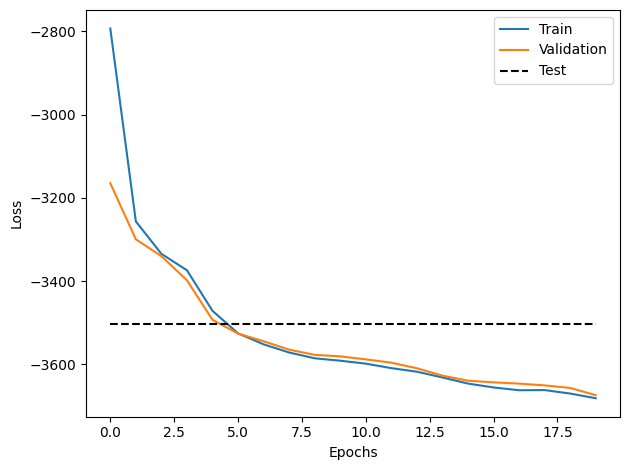

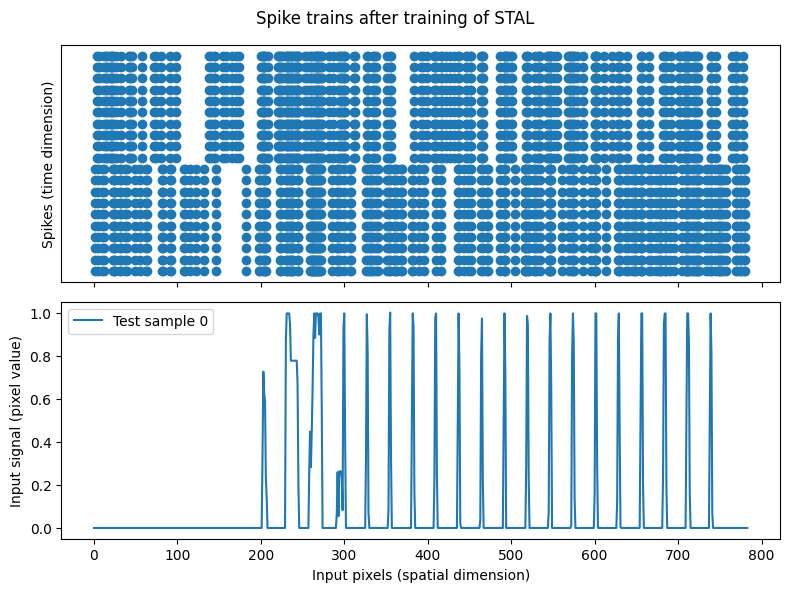

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import time

from mnist.load_mnist import load_mnist
from STAL.LAST import LearningAdaptiveSpikeThresholds as SpikeThresholdAdaptiveLearning
# from STAL_loss.loss_low_sp import DefaultLoss
# from STAL_loss.default_loss import DefaultLoss
from STAL_loss.only_mi_loss import MILoss as DefaultLoss

device = torch.device("mps")

train_X, train_y, test_X, test_y = load_mnist()

# test_X = test_X[:1000] # TODO: revert this
# test_y = test_y[:1000]

print(train_X[0].shape, train_y[0])

omega = train_X[0].size(0)
psi = 20
c = 1

# Add channel dimension with size c
train_X = train_X.unsqueeze(1)
test_X = test_X.unsqueeze(1)

l1_sz = omega * 2 # 392
l2_sz = omega * 2 # 196
drop_p = 0.2

STAL = SpikeThresholdAdaptiveLearning(omega, psi, c, l1_sz, l2_sz, drop_p)
STAL.print_learnable_params()

batch_size = 1000
x = test_X[:batch_size]

h, Z1, Z2 = STAL(x)

theta = 0.99
spiketrain = (h > theta).float()
# [batch_size, (window_size * n_channels) * psi]

# Since we have 1 channel, let's squeeze it
B = spiketrain.reshape(batch_size, omega, c, psi).squeeze(2)

b = B[0]
pixels, spikes = np.where(b == 1)

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].scatter(pixels, (spikes/psi))
axs[0].set_ylabel("Spikes (time dimension)")
axs[0].set_yticks([])

axs[1].plot(x[0, 0], label="Test sample 0")
axs[1].set_xlabel("Input pixels (spatial dimension)")
axs[1].set_ylabel("Input signal (pixel value)")
axs[1].legend()

plt.suptitle("Spike trains from random initialisation of STAL")
plt.tight_layout()
# plt.savefig("img/random_init_example_mnist.png")
plt.show()

# Loss and Optimizer
default_loss = DefaultLoss()
optimizer = torch.optim.AdamW(STAL.parameters(), lr=0.01)

# Train/Validation
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
n_epochs = 20
# train_X = train_X[:batch_size*10] # TODO: revert this
# val_X = val_X[:batch_size*3]
# train_y = train_y[:batch_size*10]
# val_y = val_y[:batch_size*3]

STAL.to(device)

start = time.time()

train_loss = []
train_spiketrains = []
val_loss = []
val_spiketrains = []
for epoch in range(n_epochs):
    e = []
    for i in range(0, len(train_X), batch_size):
        x_train = train_X[i:i+batch_size].to(device)
        optimizer.zero_grad()
        h, Z1, Z2 = STAL(x_train)
        if epoch == n_epochs - 1:
            spiketrain = (h > theta).float()
            train_spiketrains = np.append(train_spiketrains, spiketrain.detach().cpu().numpy())
        loss = default_loss(h, x_train, Z1, Z2)
        loss.backward()
        optimizer.step()
        e.append(loss.item())
    train_loss.append(np.mean(e))
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss[-1]:.3f}")
    
    e = []
    with torch.no_grad():
        for i in range(0, len(val_X), batch_size):
            x_val = val_X[i:i+batch_size].to(device)
            h, Z1, Z2 = STAL(x_val)
            if epoch == n_epochs - 1:
                spiketrain = (h > theta).float()
                val_spiketrains = np.append(val_spiketrains, spiketrain.detach().cpu().numpy())
            loss = default_loss(h, x_val, Z1, Z2)
            e.append(loss.item())
    val_loss.append(np.mean(e))
    print(f"\t- Validation Loss: {val_loss[-1]:.3f}")

# Test
test_loss = []
test_spiketrains = []
for i in range(0, len(test_X), batch_size):
    x_test = test_X[:batch_size].to(device)
    h, Z1, Z2 = STAL(x_test)
    spiketrain = (h > theta).float()
    test_spiketrains = np.append(test_spiketrains, spiketrain.detach().cpu().numpy())
    loss = default_loss(h, x_test, Z1, Z2)
    test_loss.append(loss.item())

print("---")
print(f"Test Loss: {np.mean(test_loss):.3f}")
print("---")

end = time.time()
print(f"Training took {end-start:.2f}s")

def plot_loss(train_loss, val_loss, test_loss):
    plt.plot(train_loss, label="Train")
    plt.plot(val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.hlines(np.mean(test_loss), 0, len(train_loss) - 1, colors='black', linestyles='dashed', label="Test")
    plt.legend()
    plt.tight_layout()
    # plt.savefig("img/loss_curves_STAL_mnist")
    plt.show()

plot_loss(train_loss, val_loss, test_loss)

# Inspect the spike train after training
STAL.cpu()
STAL.eval()

B_STAL_tr = train_spiketrains.reshape(-1, omega, c, psi).squeeze(2)
B_STAL_val = val_spiketrains.reshape(-1, omega, c, psi).squeeze(2)
B_STAL_ts = test_spiketrains.reshape(-1, omega, c, psi).squeeze(2)
b = B_STAL_ts[0]
pixels, spikes = np.where(b == 1)

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].scatter(pixels, (spikes/psi))
axs[0].set_ylabel("Spikes (time dimension)")
axs[0].set_yticks([])

axs[1].plot(x[0, 0], label="Test sample 0")
axs[1].set_xlabel("Input pixels (spatial dimension)")
axs[1].set_ylabel("Input signal (pixel value)")
axs[1].legend()

plt.suptitle("Spike trains after training of STAL")
plt.tight_layout()
# plt.savefig("img/post_training_example_mnist_low_sp.png")
plt.show()

B_STAL_tr = torch.tensor(B_STAL_tr)
B_STAL_val = torch.tensor(B_STAL_val)
B_STAL_ts = torch.tensor(B_STAL_ts)


## 2. Inspecting the encoded spike trains

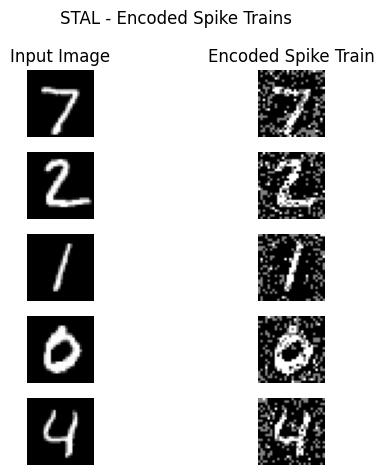

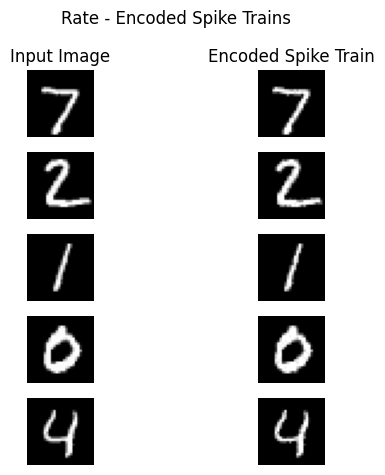

In [2]:
import snntorch as snn
from snntorch import spikegen

def plot_images(X, B, idx, title):
    fig, axs = plt.subplots(len(idx), 2)
    if len(idx) == 1:
        axs = [axs]
    
    axs[0, 0].set_title("Input Image")
    axs[0, 1].set_title("Encoded Spike Train")
    for i in idx:
        x = X[i].numpy()
        b = B[i]
        b_gray = b.mean(axis=1)
        
        axs[i, 0].imshow(x.reshape(28, 28), cmap='gray')
        axs[i, 1].imshow(b_gray.reshape(28, 28), cmap='gray')

    # Remove border
    for ax in axs.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])
    plt.suptitle(f"{title} - Encoded Spike Trains")
    plt.tight_layout()

plot_images(test_X, B_STAL_ts, np.arange(5), "STAL")

# Swap indices to match B_STAL's shape
B_rate_tr = spikegen.rate(train_X, psi).permute(1,2,3,0).squeeze(1)
B_rate_val = spikegen.rate(val_X, psi).permute(1,2,3,0).squeeze(1)
B_rate_ts = spikegen.rate(test_X, psi).permute(1,2,3,0).squeeze(1)

plot_images(test_X, B_rate_ts, np.arange(5), "Rate")

Converting the spiketrains to the format for snntorch: [spike dim, batch size, input size], i.e.: [psi, batch_size, num_pixels].

In [3]:
print(B_rate_ts.shape, B_STAL_ts.shape)
# bsz, pixels, psi -> psi, bsz, pixels

B_rate_tr = B_rate_tr.permute(2, 0, 1)
B_rate_val = B_rate_val.permute(2, 0, 1)
B_rate_ts = B_rate_ts.permute(2, 0, 1)

B_STAL_tr = B_STAL_tr.permute(2, 0, 1)
B_STAL_val = B_STAL_val.permute(2, 0, 1)
B_STAL_ts = B_STAL_ts.permute(2, 0, 1)

print(B_rate_ts.shape, B_STAL_ts.shape)
# psi, bsz, pixels


torch.Size([10000, 784, 20]) torch.Size([10000, 784, 20])
torch.Size([20, 10000, 784]) torch.Size([20, 10000, 784])


## 3. Training simple SNN

a. Train the SNN on rate-coded spike trains \
b. Train it on the STAL spike trains \
c. Compare the performances.

In [56]:
class MNIST_SNN(torch.nn.Module):
    def __init__(self):
        super(MNIST_SNN, self).__init__()
        self.lif1 = snn.LeakyParallel(input_size=28*28, hidden_size=5000, dropout=0.2)
        self.lif2 = snn.LeakyParallel(input_size=5000, hidden_size=10, dropout=0.2)
        # self.lif3 = snn.LeakyParallel(input_size=28*28*2, hidden_size=10, dropout=0.2)
        
    def forward(self, x):
        x = self.lif1(x)
        x = self.lif2(x)
        # x = self.lif3(x)
        return x
    
snn_model = MNIST_SNN()
snn_model

MNIST_SNN(
  (lif1): LeakyParallel(
    (rnn): RNN(784, 5000, dropout=0.2)
  )
  (lif2): LeakyParallel(
    (rnn): RNN(5000, 10, dropout=0.2)
  )
)

The training logic:

In [57]:
from snntorch import functional as SF

batch_size = 64

def train_test(B_tr, train_y, B_val, val_y, B_ts, test_y, spiking_loss, cls_epochs=100, lr=1e-3):
    snn_model = MNIST_SNN()
    snn_model.to(device)
    optimizer = torch.optim.AdamW(snn_model.parameters(), lr=lr)

    # Train
    train_loss = []
    val_loss = []

    start = time.time()
    for epoch in range(cls_epochs):
        e = []
        for i in range(0, len(B_tr), batch_size):
            x_train = B_tr[:, i:i+batch_size].float().to(device)
            y_train = train_y[i:i+batch_size].long().to(device)
            optimizer.zero_grad()

            spk = snn_model(x_train)
            loss = spiking_loss(spk, y_train)
            loss.backward()
            optimizer.step()
            e.append(loss.item())
        train_loss.append(np.mean(e))
        print(f"Epoch {epoch + 1} - Train Loss: {train_loss[-1]:.3f}")
        
        # Validation
        e = []
        with torch.no_grad():
            for i in range(0, len(B_val), batch_size):
                x_val = B_val[:, i:i+batch_size].float().to(device)
                y_val = val_y[i:i+batch_size].long().to(device)
                spk = snn_model(x_val)
                loss = spiking_loss(spk, y_val)
                e.append(loss.item())
        val_loss.append(np.mean(e))
        print(f"\t- Validation Loss: {val_loss[-1]:.3f}")
        
    # Test
    e = []
    test_loss = []
    test_acc1 = []
    test_acc2 = []
    with torch.no_grad():
        for i in range(0, len(B_ts), batch_size):
            x_test = B_ts[:, i:i+batch_size].float().to(device)
            y_test = test_y[i:i+batch_size].long().to(device)
            
            spk = snn_model(x_test)
            loss = spiking_loss(spk, y_test)
            test_loss.append(loss.item())

            test_acc1.append(SF.acc.accuracy_rate(spk, y_test))
            test_acc2.append(SF.acc.accuracy_temporal(spk, y_test))
            e.append(loss.item())

    plot_loss(train_loss, val_loss, test_loss)

    print(f"Test Loss: {np.mean(e):.3f}")
    print(f"Rate: {np.mean(test_acc1)*100:.2f}% accuracy on test set")
    print(f"Temporal: {np.mean(test_acc2)*100:.2f}% accuracy on test set")

    end = time.time()
    print(f"Training took {end-start:.2f}s")
    
    return np.mean(test_acc1)*100, np.mean(test_acc2)*100

#### a. Train on Rate
In two settings: using rate information to compute loss and accuracy, and using temporal information. We'll compare the results.

Epoch 1 - Train Loss: 2.303
	- Validation Loss: 2.303
Epoch 2 - Train Loss: 2.303
	- Validation Loss: 2.303
Epoch 3 - Train Loss: 2.303
	- Validation Loss: 2.303
Epoch 4 - Train Loss: 2.303
	- Validation Loss: 2.303
Epoch 5 - Train Loss: 2.303
	- Validation Loss: 2.292
Epoch 6 - Train Loss: 2.289
	- Validation Loss: 2.251
Epoch 7 - Train Loss: 2.253
	- Validation Loss: 2.207
Epoch 8 - Train Loss: 2.209
	- Validation Loss: 2.193
Epoch 9 - Train Loss: 2.159
	- Validation Loss: 2.166
Epoch 10 - Train Loss: 2.112
	- Validation Loss: 2.145
Epoch 11 - Train Loss: 2.033
	- Validation Loss: 2.133
Epoch 12 - Train Loss: 1.968
	- Validation Loss: 2.088
Epoch 13 - Train Loss: 1.886
	- Validation Loss: 2.064
Epoch 14 - Train Loss: 1.827
	- Validation Loss: 2.037
Epoch 15 - Train Loss: 1.797
	- Validation Loss: 2.024
Epoch 16 - Train Loss: 1.774
	- Validation Loss: 2.021
Epoch 17 - Train Loss: 1.744
	- Validation Loss: 2.014
Epoch 18 - Train Loss: 1.728
	- Validation Loss: 2.007
Epoch 19 - Train Lo

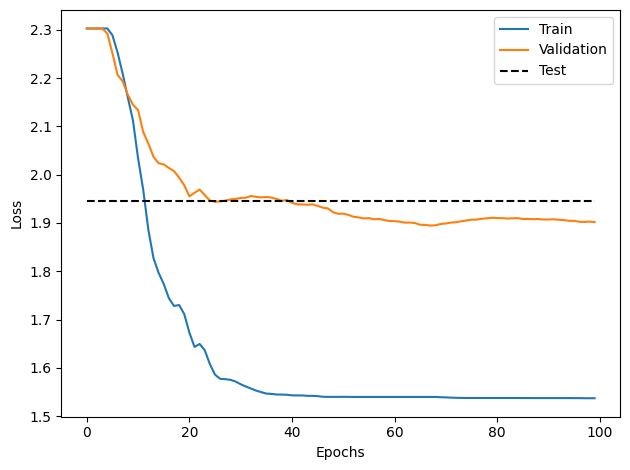

Test Loss: 1.946
Rate: 50.00% accuracy on test set
Temporal: 48.44% accuracy on test set
Training took 10.32s


In [58]:
# Rate 1: rate loss and rate used to compute accuracy
spiking_loss = SF.ce_rate_loss()

test_acc_rate1, test_acc_rate2 = train_test(B_rate_tr, train_y, B_rate_val, val_y, B_rate_ts, test_y, spiking_loss)

#### b. Train on STAL

Again, in two settings: using rate information to compute loss and accuracy, and using temporal information. We'll compare the results.

Epoch 1 - Train Loss: 2.303
	- Validation Loss: 2.303
Epoch 2 - Train Loss: 2.303
	- Validation Loss: 2.303
Epoch 3 - Train Loss: 2.303
	- Validation Loss: 2.303
Epoch 4 - Train Loss: 2.291
	- Validation Loss: 2.253
Epoch 5 - Train Loss: 2.122
	- Validation Loss: 2.229
Epoch 6 - Train Loss: 2.013
	- Validation Loss: 2.170
Epoch 7 - Train Loss: 1.893
	- Validation Loss: 2.136
Epoch 8 - Train Loss: 1.865
	- Validation Loss: 2.097
Epoch 9 - Train Loss: 1.769
	- Validation Loss: 2.099
Epoch 10 - Train Loss: 1.628
	- Validation Loss: 2.013
Epoch 11 - Train Loss: 1.585
	- Validation Loss: 1.948
Epoch 12 - Train Loss: 1.555
	- Validation Loss: 1.920
Epoch 13 - Train Loss: 1.533
	- Validation Loss: 1.967
Epoch 14 - Train Loss: 1.557
	- Validation Loss: 2.031
Epoch 15 - Train Loss: 1.551
	- Validation Loss: 2.058
Epoch 16 - Train Loss: 1.548
	- Validation Loss: 2.071
Epoch 17 - Train Loss: 1.553
	- Validation Loss: 2.076
Epoch 18 - Train Loss: 1.544
	- Validation Loss: 2.067
Epoch 19 - Train Lo

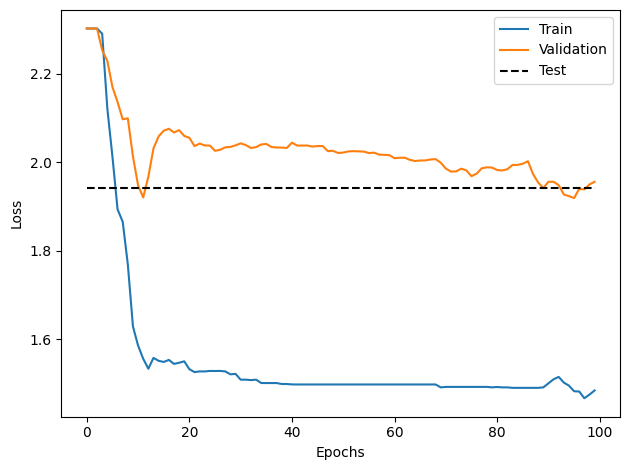

Test Loss: 1.942
Rate: 50.00% accuracy on test set
Temporal: 51.56% accuracy on test set
Training took 10.39s


In [59]:
# STAL 1: rate loss and rate used to compute accuracy

test_acc_stal1, test_acc_stal2 = train_test(B_STAL_tr, train_y, B_STAL_val, val_y, B_STAL_ts, test_y, spiking_loss)

#### c. Compare Rate v. STAL

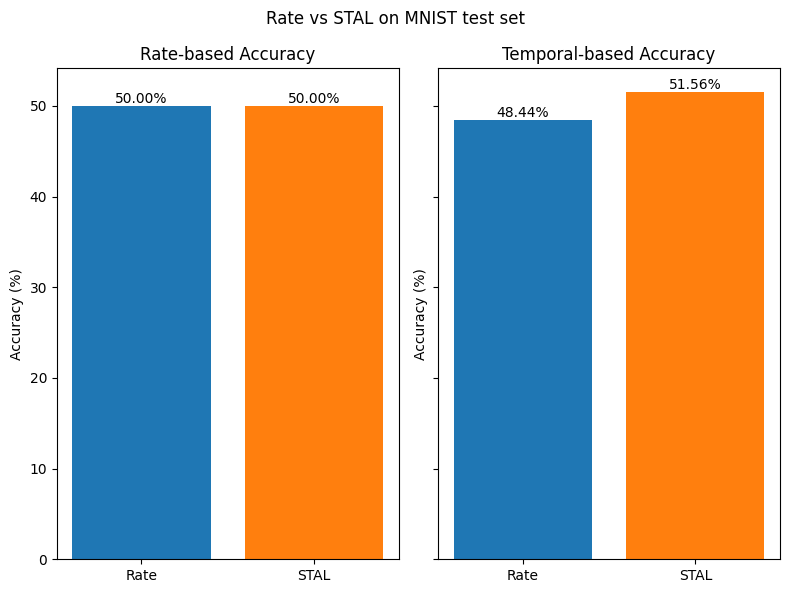

In [61]:
c = plt.cm.tab10.colors

fig, axs = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
axs[0].bar(["Rate", "STAL"], [test_acc_rate1, test_acc_stal1], color=c)
axs[0].text(0, test_acc_rate1, f"{test_acc_rate1:.2f}%", ha='center', va='bottom')
axs[0].text(1, test_acc_stal1, f"{test_acc_stal1:.2f}%", ha='center', va='bottom')
axs[0].set_ylabel("Accuracy (%)")
axs[0].set_title("Rate-based Accuracy")

axs[1].bar(["Rate", "STAL"], [test_acc_rate2, test_acc_stal2], color=c)
axs[1].text(0, test_acc_rate2, f"{test_acc_rate2:.2f}%", ha='center', va='bottom')
axs[1].text(1, test_acc_stal2, f"{test_acc_stal2:.2f}%", ha='center', va='bottom')
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("Temporal-based Accuracy")

plt.suptitle("Rate vs STAL on MNIST test set")
plt.tight_layout()
plt.show()

Since the rate-coding method encodes solely in the spatial domain (pixels) and randomly in the temporal domain (psi), we expect this method to perform more poorly when the accuracy is computed using the spike times (temporal-based accuracy).

And since the STAL encoder utilizes both spatial and temporal dimensions to encode the spikes, we expect this method to outperform the rate-coding method, especially when computing the accuracy using temporally-based.